In [6]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import linear_model
from imblearn.ensemble import BalancedRandomForestClassifier
import pickle
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [7]:
data = pd.read_csv("processed_data.csv")

offense_columns = [
    'offense_name_CyberCrime', 'offense_name_DrugCrime', 'offense_name_Fraud',
    'offense_name_Gambling', 'offense_name_OtherCrime', 'offense_name_PropertyCrime',
    'offense_name_SexCrime', 'offense_name_ViolentCrime', 'offense_name_WeaponCrime'
]

data['offense_name_combined'] = data[offense_columns].idxmax(axis=1)

min_samples = 1000
class_counts = data['offense_name_combined'].value_counts()
low_count_classes = class_counts[class_counts < min_samples].index.tolist()

data['offense_name_combined'] = data['offense_name_combined'].apply(
    lambda x: x if x not in low_count_classes else 'offense_name_Other'
)

X = data.drop(offense_columns + ['offense_name_combined'], axis=1)
y = data['offense_name_combined']

data_combined = pd.concat([X, y], axis=1)
data_combined = data_combined.dropna()
X = data_combined.drop('offense_name_combined', axis=1)
y = data_combined['offense_name_combined']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [12]:
def predict_sgd_svm(x_train, y_train, x_test=None):
    sgd_svm = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, random_state=42)
    sgd_svm.fit(x_train, y_train)
    if x_test is not None:
        y_prediction = sgd_svm.predict(x_test)
        return sgd_svm, y_prediction
    return sgd_svm

def predict_balanced_random_forest(x, Y):
    balanced_random_forest = BalancedRandomForestClassifier(
        n_estimators=100,
        random_state=42,
        sampling_strategy='all',
        replacement=True,
        bootstrap=False,
        n_jobs=-1
    )
    balanced_random_forest.fit(x, Y)
    return balanced_random_forest


def predict_logistic_regression(x, Y, z=None):
    logistic_regression = LogisticRegression(solver='saga', max_iter=1000)
    logistic_regression.fit(x, Y)
    if z is not None:
        y_prediction = logistic_regression.predict(z)
        return logistic_regression, y_prediction
    return logistic_regression

def knn_algorithm(x, Y, z = 7):
    knn_prediction = KNeighborsClassifier(n_neighbors=z)
    knn_prediction.fit(x, Y)
    return knn_prediction

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(title)
    plt.show()


In [9]:
print("Models before using SMOTE:")


Models before using SMOTE:


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Logistic Regression Model Performance:
                            precision    recall  f1-score   support

    offense_name_DrugCrime       0.78      0.82      0.80       335
        offense_name_Fraud       0.00      0.00      0.00       230
        offense_name_Other       0.00      0.00      0.00       333
offense_name_PropertyCrime       0.86      0.67      0.75     13043
 offense_name_ViolentCrime       0.81      0.95      0.88     21185

                  accuracy                           0.83     35126
                 macro avg       0.49      0.49      0.49     35126
              weighted avg       0.82      0.83      0.82     35126

Accuracy: 0.8278767864260093


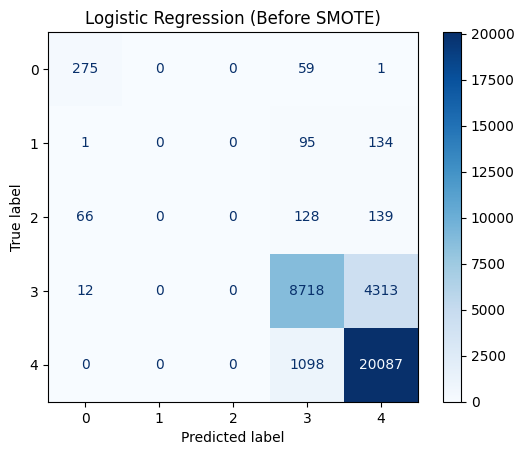

In [10]:
# Logistic Regression
logistic_model, logistic_predictions = predict_logistic_regression(X_train, y_train, X_test)
print("\nLogistic Regression Model Performance:")
print(classification_report(y_test, logistic_predictions, zero_division=0))
print("Accuracy:", accuracy_score(y_test, logistic_predictions))
pickle.dump(logistic_model, open("logistic_model_before_smote.pkl", "wb"))
plot_confusion_matrix(y_test, logistic_predictions, "Logistic Regression (Before SMOTE)")


SGD-based SVM Model Performance:
                            precision    recall  f1-score   support

    offense_name_DrugCrime       0.74      0.81      0.77       335
        offense_name_Fraud       0.00      0.00      0.00       230
        offense_name_Other       0.14      0.07      0.09       333
offense_name_PropertyCrime       0.94      0.56      0.70     13043
 offense_name_ViolentCrime       0.78      0.99      0.87     21185

                  accuracy                           0.81     35126
                 macro avg       0.52      0.48      0.49     35126
              weighted avg       0.83      0.81      0.79     35126

Accuracy: 0.8106815464328417


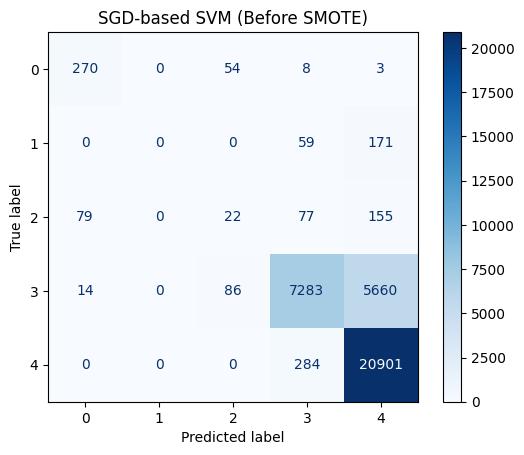

In [13]:
# SGD-based SVM
sgd_svm_model, sgd_svm_predictions = predict_sgd_svm(X_train, y_train, X_test)
print("\nSGD-based SVM Model Performance:")
print(classification_report(y_test, sgd_svm_predictions, zero_division=0))
print("Accuracy:", accuracy_score(y_test, sgd_svm_predictions))
pickle.dump(sgd_svm_model, open("sgd_svm_model_before_smote.pkl", "wb"))
plot_confusion_matrix(y_test, sgd_svm_predictions, "SGD-based SVM (Before SMOTE)")


KNN Model Performance:
                            precision    recall  f1-score   support

    offense_name_DrugCrime       0.78      0.39      0.52       335
        offense_name_Fraud       0.40      0.01      0.02       230
        offense_name_Other       0.12      0.00      0.01       333
offense_name_PropertyCrime       0.82      0.65      0.72     13043
 offense_name_ViolentCrime       0.80      0.92      0.86     21185

                  accuracy                           0.80     35126
                 macro avg       0.58      0.39      0.42     35126
              weighted avg       0.80      0.80      0.79     35126

Accuracy: 0.8024540226612765


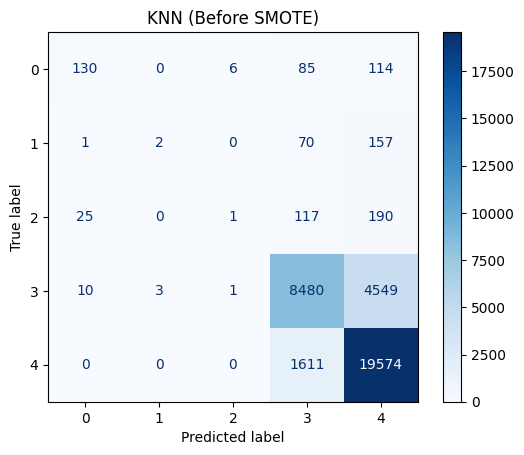

In [14]:
# KNN
knn_model = knn_algorithm(X_train, y_train)
knn_predictions = knn_model.predict(X_test)
print("\nKNN Model Performance:")
print(classification_report(y_test, knn_predictions, zero_division=0))
print("Accuracy:", accuracy_score(y_test, knn_predictions))
pickle.dump(knn_model, open("knn_model_before_smote.pkl", "wb"))
plot_confusion_matrix(y_test, knn_predictions, "KNN (Before SMOTE)")


Balanced Random Forest Model Performance:
                            precision    recall  f1-score   support

    offense_name_DrugCrime       0.67      0.94      0.78       335
        offense_name_Fraud       0.04      0.59      0.08       230
        offense_name_Other       0.06      0.21      0.09       333
offense_name_PropertyCrime       0.85      0.67      0.75     13043
 offense_name_ViolentCrime       0.88      0.83      0.85     21185

                  accuracy                           0.76     35126
                 macro avg       0.50      0.65      0.51     35126
              weighted avg       0.85      0.76      0.80     35126

Accuracy: 0.7618857826111712


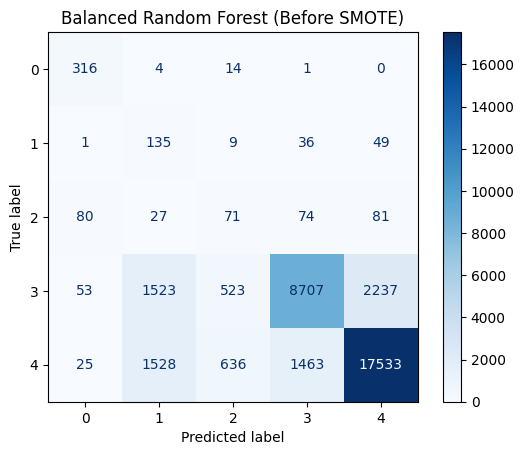

In [15]:
# Balanced Random Forest
rbf_model = predict_balanced_random_forest(X_train, y_train)
rbf_predictions = rbf_model.predict(X_test)
print("\nBalanced Random Forest Model Performance:")
print(classification_report(y_test, rbf_predictions, zero_division=0))
print("Accuracy:", accuracy_score(y_test, rbf_predictions))
pickle.dump(rbf_model, open("balanced_random_forest_before_smote.pkl", "wb"))
plot_confusion_matrix(y_test, rbf_predictions, "Balanced Random Forest (Before SMOTE)")

In [16]:
# Train and save models after using SMOTE
print("\n\n\nModels after using SMOTE:")




Models after using SMOTE:


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Logistic Regression Model Performance with SMOTE:
                            precision    recall  f1-score   support

    offense_name_DrugCrime       0.59      0.98      0.74       335
        offense_name_Fraud       0.06      0.15      0.08       230
        offense_name_Other       0.07      0.02      0.03       333
offense_name_PropertyCrime       0.84      0.70      0.76     13043
 offense_name_ViolentCrime       0.84      0.91      0.87     21185

                  accuracy                           0.82     35126
                 macro avg       0.48      0.55      0.50     35126
              weighted avg       0.82      0.82      0.82     35126

Accuracy: 0.8175710300062632


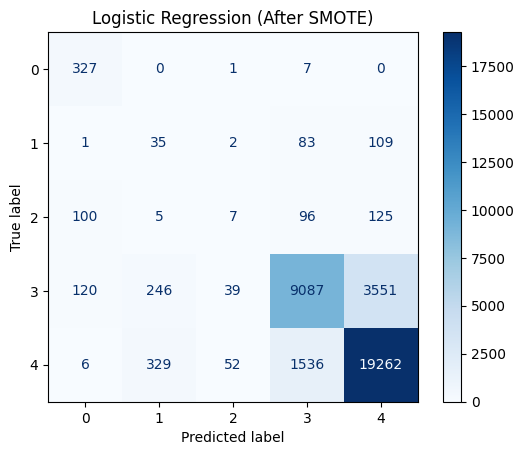

In [17]:
# Logistic Regression
logistic_model_smote, logistic_predictions_smote = predict_logistic_regression(X_train_resampled, y_train_resampled, X_test)
print("\nLogistic Regression Model Performance with SMOTE:")
print(classification_report(y_test, logistic_predictions_smote, zero_division=0))
print("Accuracy:", accuracy_score(y_test, logistic_predictions_smote))
pickle.dump(logistic_model_smote, open("logistic_model_after_smote.pkl", "wb"))
plot_confusion_matrix(y_test, logistic_predictions_smote, "Logistic Regression (After SMOTE)")


SGD-based SVM Model Performance with SMOTE:
                            precision    recall  f1-score   support

    offense_name_DrugCrime       0.60      0.96      0.74       335
        offense_name_Fraud       0.08      0.07      0.07       230
        offense_name_Other       0.03      0.01      0.01       333
offense_name_PropertyCrime       0.81      0.74      0.77     13043
 offense_name_ViolentCrime       0.85      0.89      0.87     21185

                  accuracy                           0.82     35126
                 macro avg       0.47      0.53      0.49     35126
              weighted avg       0.82      0.82      0.82     35126

Accuracy: 0.8240334794738939


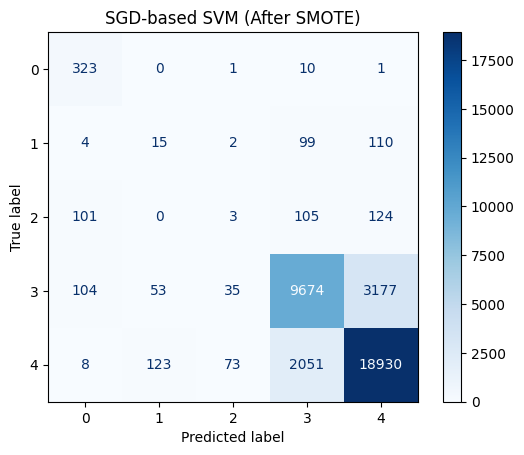

In [18]:
# SGD-based SVM
sgd_svm_model_smote = predict_sgd_svm(X_train_resampled, y_train_resampled)
sgd_svm_predictions_smote = sgd_svm_model_smote.predict(X_test)
print("\nSGD-based SVM Model Performance with SMOTE:")
print(classification_report(y_test, sgd_svm_predictions_smote, zero_division=0))
print("Accuracy:", accuracy_score(y_test, sgd_svm_predictions_smote))
pickle.dump(sgd_svm_model_smote, open("sgd_svm_model_after_smote.pkl", "wb"))
plot_confusion_matrix(y_test, sgd_svm_predictions_smote, "SGD-based SVM (After SMOTE)")


KNN Model Performance with SMOTE:
                            precision    recall  f1-score   support

    offense_name_DrugCrime       0.35      0.72      0.47       335
        offense_name_Fraud       0.02      0.20      0.04       230
        offense_name_Other       0.02      0.17      0.04       333
offense_name_PropertyCrime       0.73      0.63      0.68     13043
 offense_name_ViolentCrime       0.85      0.75      0.80     21185

                  accuracy                           0.70     35126
                 macro avg       0.40      0.49      0.41     35126
              weighted avg       0.79      0.70      0.74     35126

Accuracy: 0.6952399931674543


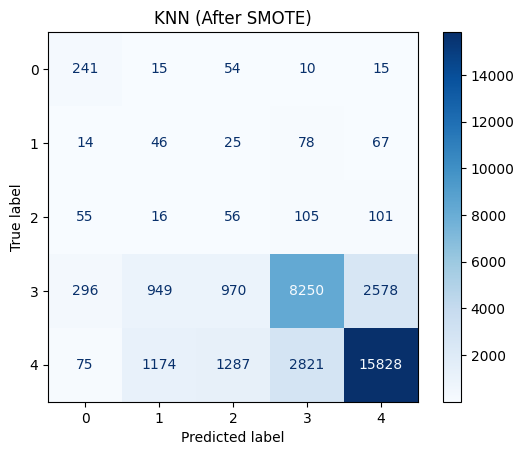

In [19]:
# KNN
knn_model_smote = knn_algorithm(X_train_resampled, y_train_resampled)
knn_predictions_smote = knn_model_smote.predict(X_test)
print("\nKNN Model Performance with SMOTE:")
print(classification_report(y_test, knn_predictions_smote, zero_division=0))
print("Accuracy:", accuracy_score(y_test, knn_predictions_smote))
pickle.dump(knn_model_smote, open("knn_model_after_smote.pkl", "wb"))
plot_confusion_matrix(y_test, knn_predictions_smote, "KNN (After SMOTE)")


Balanced Random Forest Model Performance with SMOTE:
                            precision    recall  f1-score   support

    offense_name_DrugCrime       0.78      0.92      0.85       335
        offense_name_Fraud       0.26      0.02      0.04       230
        offense_name_Other       0.39      0.09      0.14       333
offense_name_PropertyCrime       0.85      0.77      0.81     13043
 offense_name_ViolentCrime       0.86      0.92      0.89     21185

                  accuracy                           0.85     35126
                 macro avg       0.63      0.55      0.55     35126
              weighted avg       0.85      0.85      0.85     35126

Accuracy: 0.8546945282696577


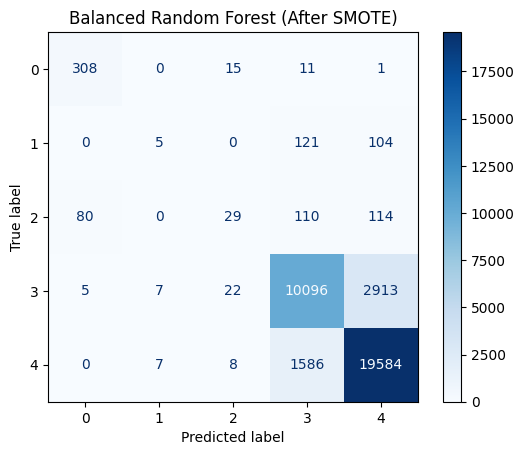

In [20]:
# Balanced Random Forest
rbf_model_smote = predict_balanced_random_forest(X_train_resampled, y_train_resampled)
rbf_predictions_smote = rbf_model_smote.predict(X_test)
print("\nBalanced Random Forest Model Performance with SMOTE:")
print(classification_report(y_test, rbf_predictions_smote, zero_division=0))
print("Accuracy:", accuracy_score(y_test, rbf_predictions_smote))
pickle.dump(rbf_model_smote, open("balanced_random_forest_after_smote.pkl", "wb"))
plot_confusion_matrix(y_test, rbf_predictions_smote, "Balanced Random Forest (After SMOTE)")